In [1]:
# Jupyter autoreload for development
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

import proteopy as pr  # Convention: import proteopy as pr
from proteopy.utils import is_proteodata, check_proteodata

random.seed(42)

cwd = Path('.').resolve()
root = cwd.parents[1]
os.chdir(root)

In [3]:
adata = pr.read.long(
    intensities="data/bludau-2021_mouse-tissue_intensities.txt",
    level="peptide",
    sep="\t",
    sample_annotation="data/bludau-2021_mouse-tissue_fraction_annotation.txt",
    column_map={"sample_id": "filename"},
    fill_na=0,
    )

# Parse `tissue` and `mouse` from `sample_id`
parts = adata.obs['sample_id'].str.split('_', n=1, expand=True)
parts = adata.obs['sample_id'].str.split('_', n=1, expand=True)
parts.columns = ['p1', 'p2']
tissue_first = parts['p1'].str.fullmatch(r'[Brain|BAT|Heart|Liver|Quad]+').copy()
adata.obs['tissue'] = np.where(tissue_first, parts['p1'], parts['p2']).copy()
adata.obs['mouse']  = np.where(tissue_first, parts['p2'], parts['p1']).copy()

# Remove irrelevant proteins
protein_excl = ['iRT_protein']
mask = ~adata.var['protein_id'].isin(protein_excl)
adata = adata[:, mask].copy()

# Good proteopy coding practice
print("Is proteodata: ", is_proteodata(adata))

adata

Is proteodata:  (True, 'peptide')


AnnData object with n_obs × n_vars = 40 × 32679
    obs: 'sample_id', 'fraction_number', 'tissue', 'mouse'
    var: 'peptide_id', 'protein_id'

In [4]:
adata.var_names[:10].to_list()

['AAAAAAAAAAAAAAAGAAGK',
 'AAAAADLANR',
 'AAAADGEPLHNEEER',
 'AAAAEGARPLER',
 'AAAAKEEAPK',
 'AAAANLC(UniMod:4)PGDVILAIDGFGTESMTHADAQDR',
 'AAAAYALGR',
 'AAADLM(UniMod:35)AYC(UniMod:4)EAHAKEDPLLTPVPASENPFR',
 'AAADLMAYC(UniMod:4)EAHAK',
 'AAADLMAYC(UniMod:4)EAHAKEDPLLTPVPASENPFR']

In [5]:
pr.pp.summarize_modifications(adata, method="sum", skip_na=True, verbose=True)

Stripping modifications: 32679 peptides -> 30781 unique stripped sequences (method='sum').


In [6]:
# Colors for plotting
cmap = mpl.colormaps['Set2']
adata.uns['colors_tissue'] = cmap(range(5)).tolist()

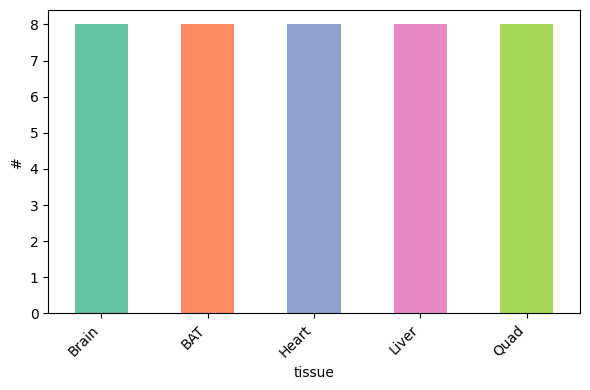

In [7]:
pr.pl.n_samples_per_category(
        adata, 
        category_key='tissue',
        color_scheme=adata.uns['colors_tissue']
        )

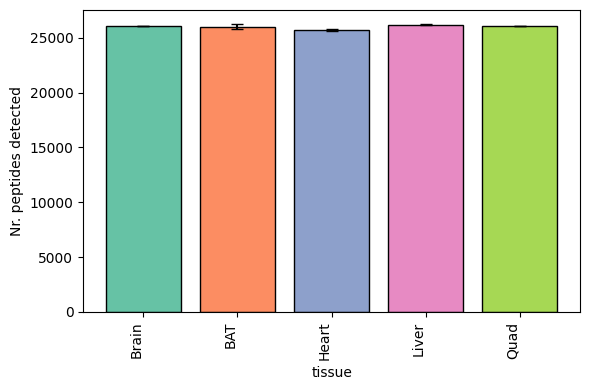

In [26]:
pr.pl.n_peptides_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    # order_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    # figsize=(9,5),
    # xlabel_rotation=45,
    )

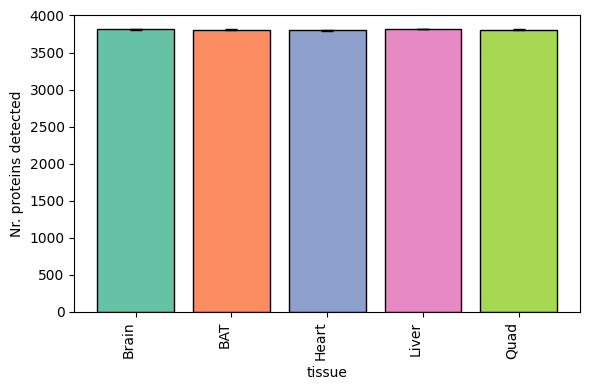

In [27]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    # order_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    # figsize=(9,5),
    # xlabel_rotation=45,
    )

In [ ]:
pr.pp.extract_peptide_groups(adata, peptide_col="peptide_id")
pr.pp.summarize_overlapping_peptides(adata)

In [23]:
adata = adata[:,~adata.var['protein_id'].str.contains(';', na=False)]

In [24]:
check_proteodata(adata)

(True, 'peptide')

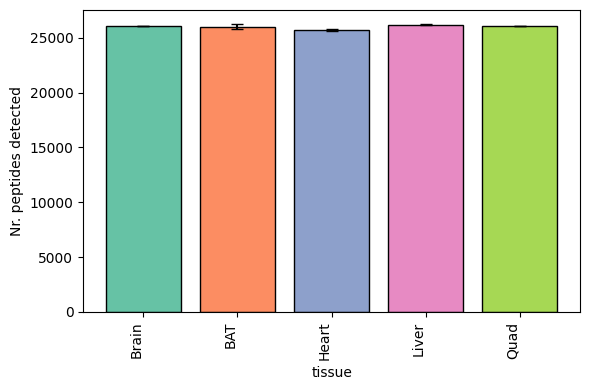

In [28]:
pr.pl.n_peptides_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    )

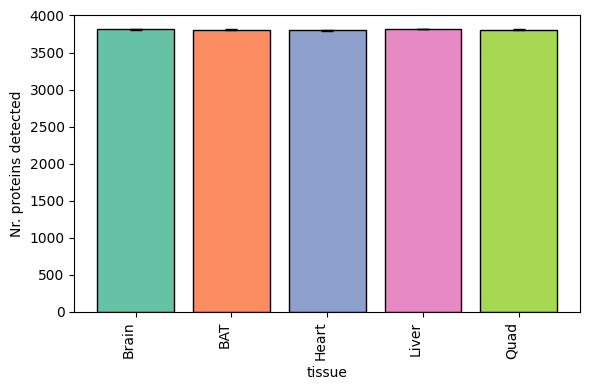

In [ ]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    )

In [29]:
pr.pp.filter_samples(adata, min_count=25000)

0 obs removed


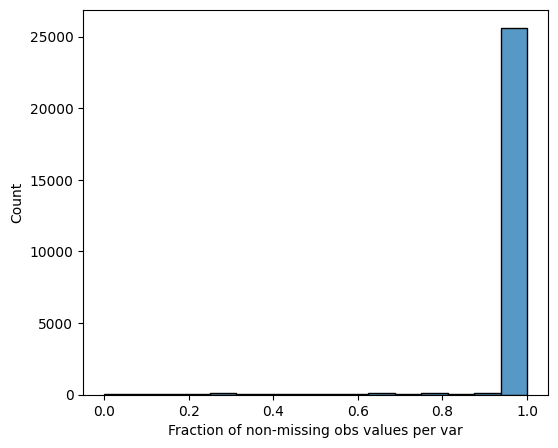

In [31]:
pr.pl.completeness_per_var(adata, zero_to_na=True)

In [ ]:
pr.pp.filter_var_completeness(adata, min_fraction=1, group_by='tissue', zero_to_na=True)
# pr.pp.filter_var_completeness(adata, min_fraction=0.5, zero_to_na=True)

108 var removed


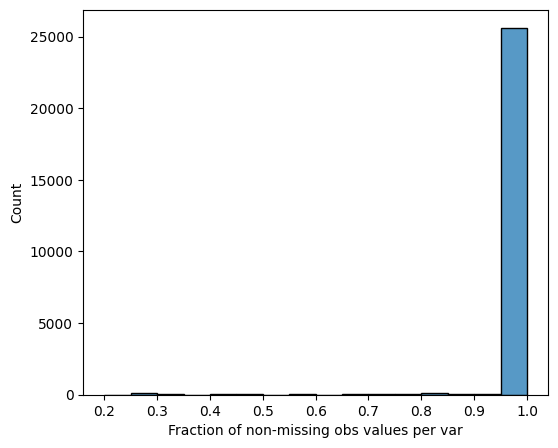

In [33]:
pr.pl.completeness_per_var(adata, zero_to_na=True)

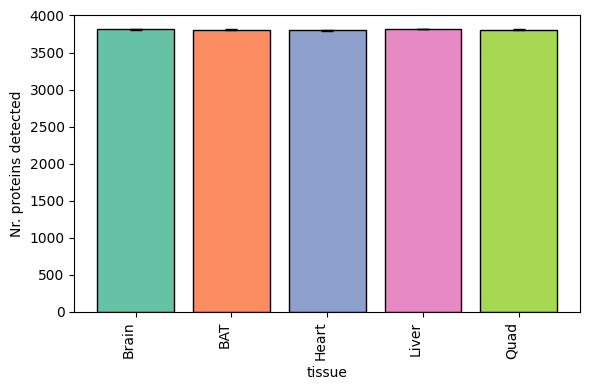

In [34]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    )

/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_


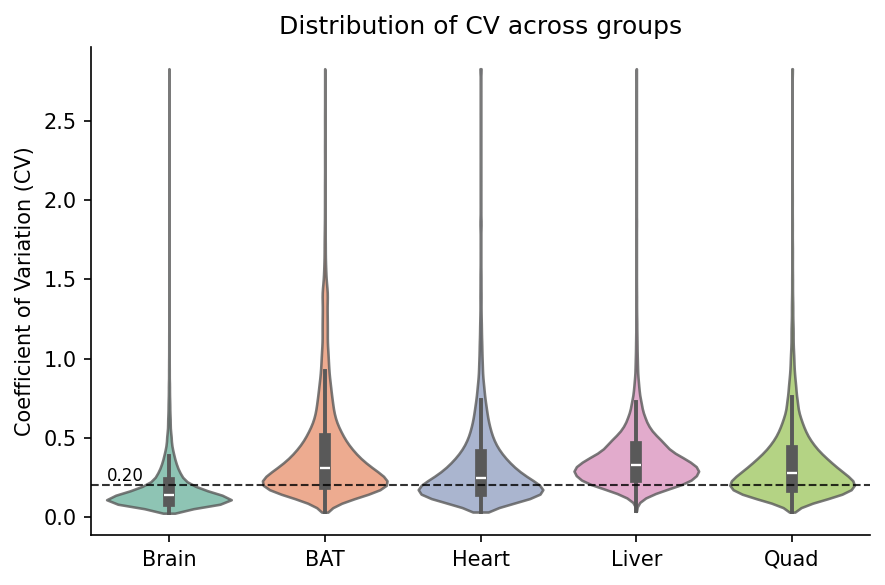

In [39]:
pr.pl.cv_by_group(
    adata,
    group_by='tissue',
    color_scheme=adata.uns["colors_tissue"],
    figsize=(6, 4),
    hline=0.2,
    )

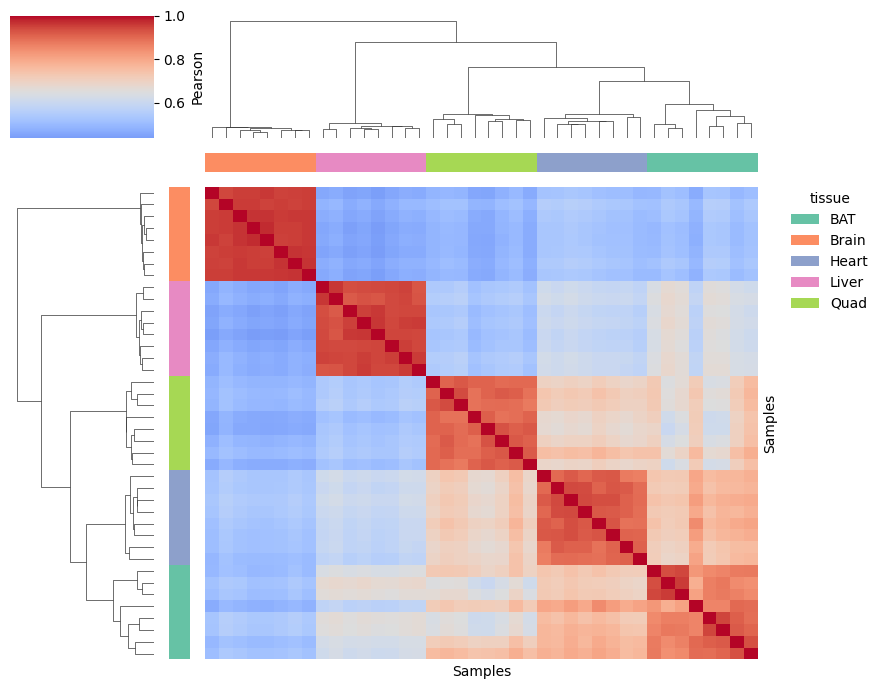

In [67]:
pr.pl.sample_correlation_matrix(
    adata,
    method="pearson",
    zero_to_na=True,
    margin_color="tissue",
    color_scheme=adata.uns["colors_tissue"],
)

In [ ]:
adata.X[adata.X == 0] = np.nan
adata.layers['raw'] = adata.X
adata.X = np.log2(adata.X)

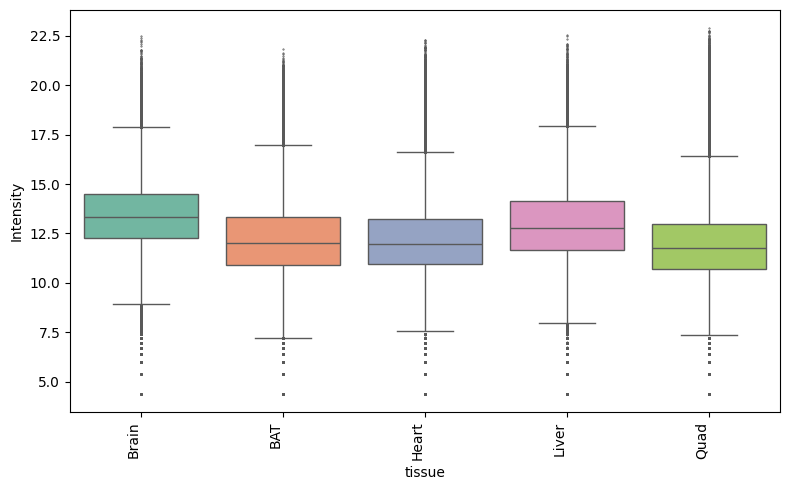

<Axes: xlabel='tissue', ylabel='Intensity'>

In [ ]:
pr.pl.intensity_box_per_sample(
    adata,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
)

In [44]:
pr.pp.normalize_median(adata, method='median_ref', log_space=True)

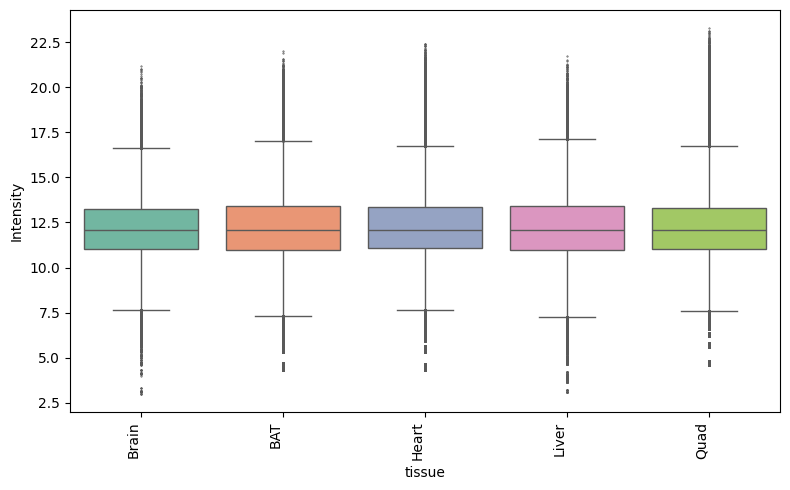

<Axes: xlabel='tissue', ylabel='Intensity'>

In [45]:
pr.pl.intensity_box_per_sample(
    adata,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
)

In [49]:
# Nr of measured and imputed values
mask = np.asarray(adata.layers["imputation_mask_X"], dtype=bool)
measured_n = int((~mask).sum())
imputed_n = int(mask.sum())
print(f"Measured: {measured_n:,} values ({100*measured_n/(measured_n+imputed_n):.1f}%)")
print(f"Imputed: {imputed_n:,} values ({100*imputed_n/(measured_n+imputed_n):.1f}%)")

Measured: 1,040,193 values (99.1%)
Imputed: 8,927 values (0.9%)


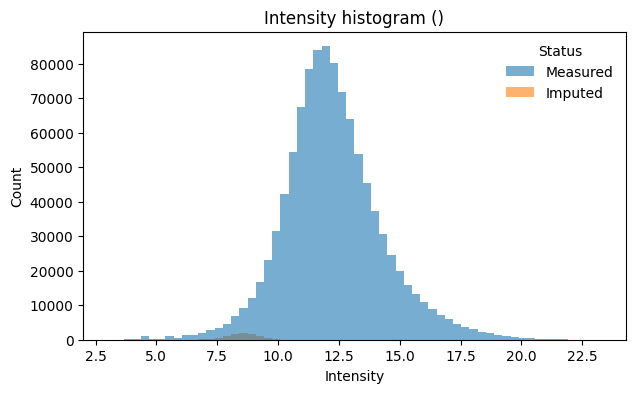

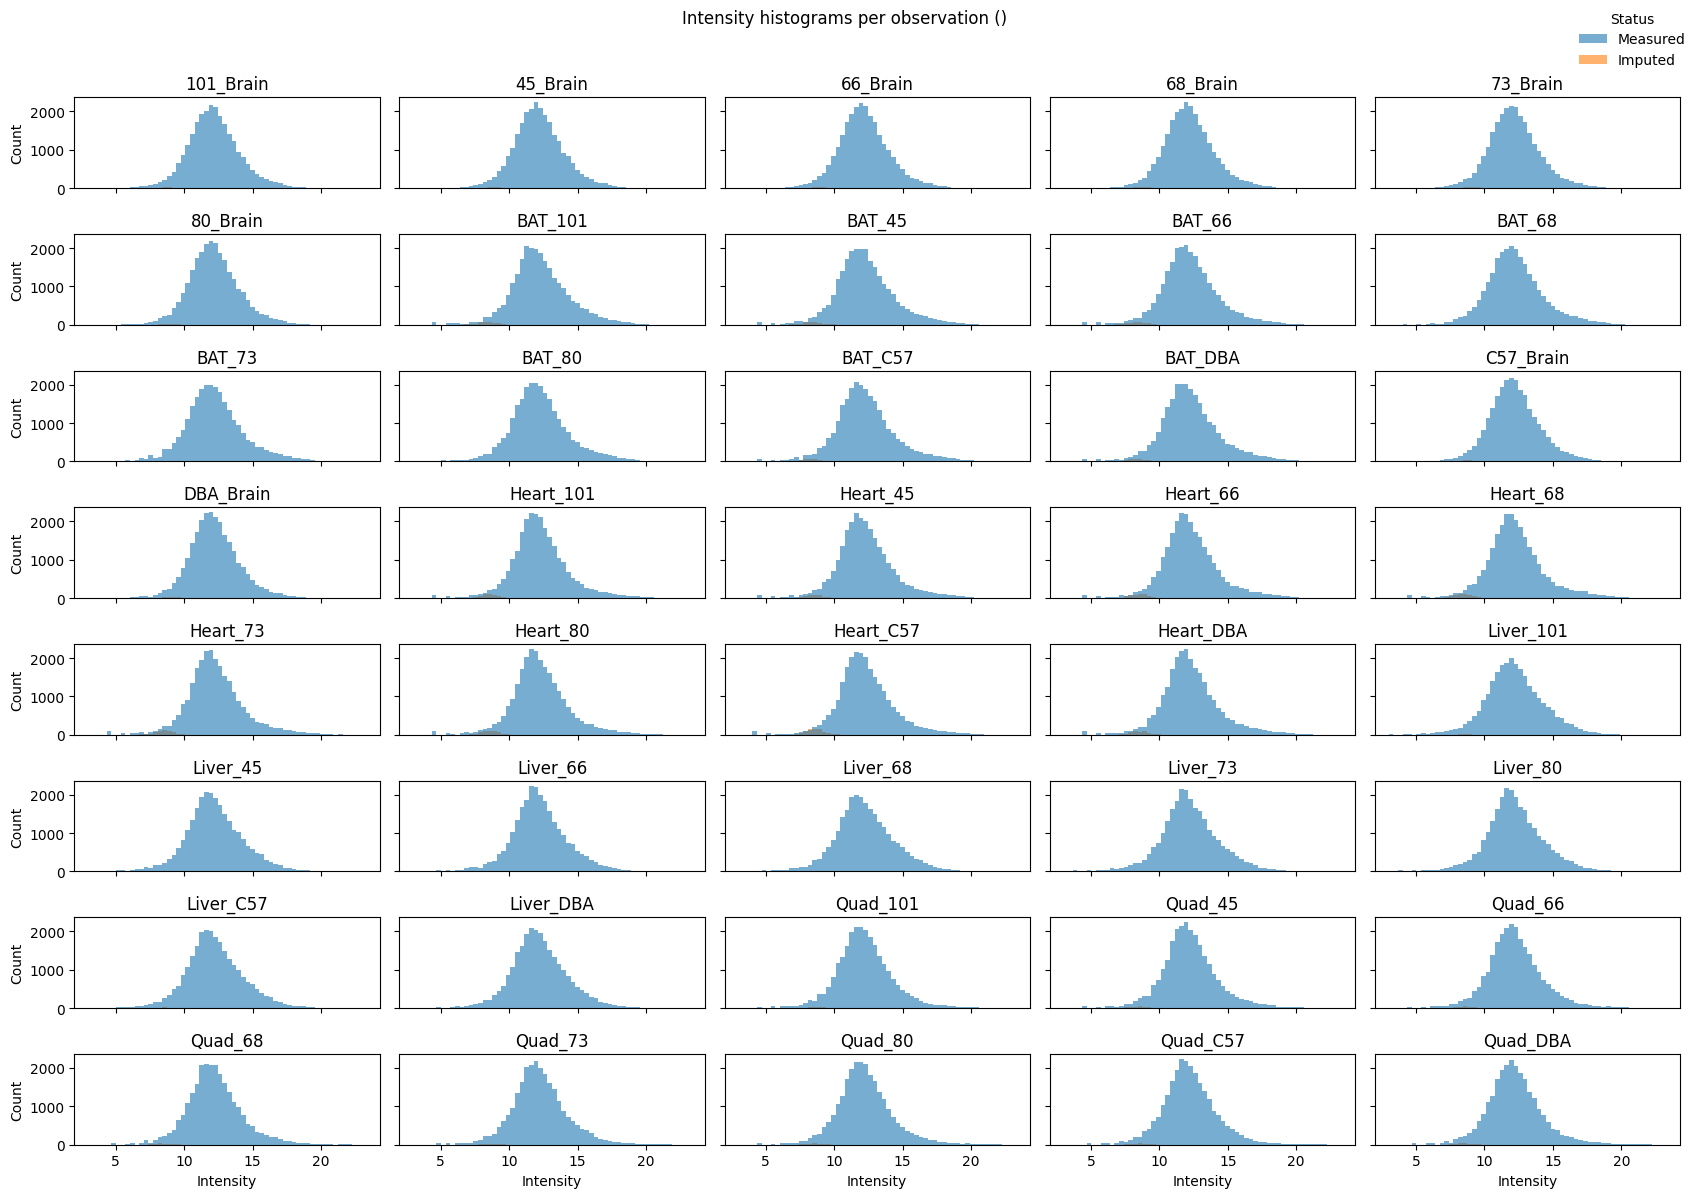

In [50]:
# Visualize intensity distribution with imputed values highlighted

# Combined histogram across all samples
pr.pl.intensity_hist(
    adata,
    color_imputed=True,  # Color imputed vs measured values differently
    density=False,
    )

# Per-sample histograms (small multiples)
pr.pl.intensity_hist(
    adata,
    color_imputed=True,
    per_obs=True,   # One subplot per sample
    ncols=5,
    legend_loc="upper right",
    density=False,
    figsize=(17, 12),
    )

In [51]:
adata.X[np.isnan(adata.X)] = 0

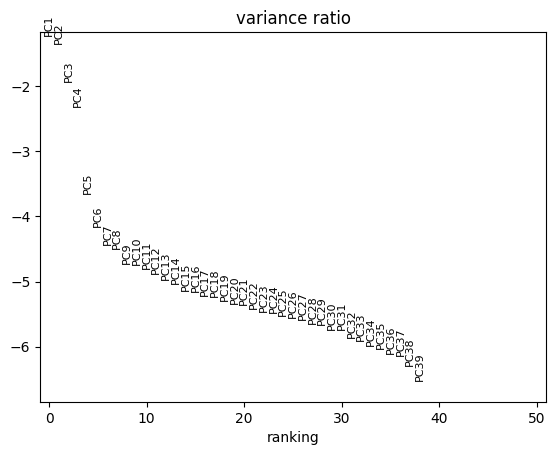

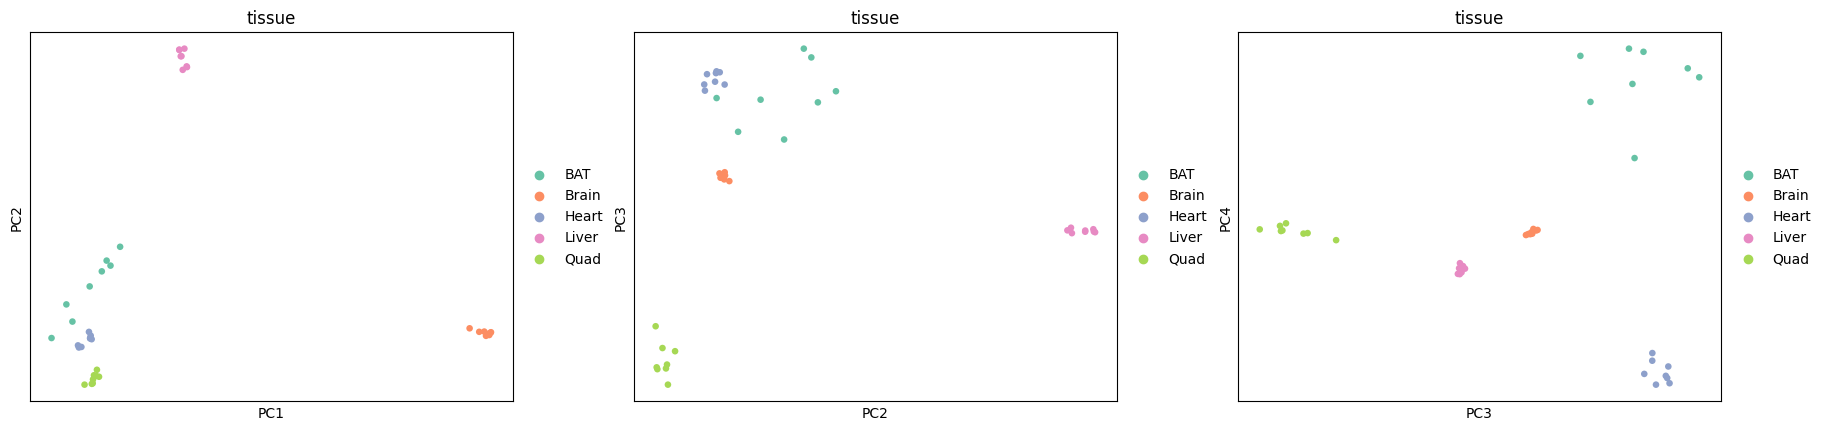

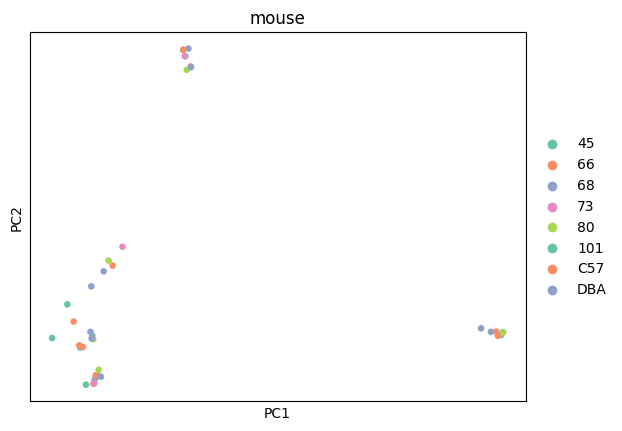

In [55]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=['tissue', 'tissue', 'tissue'],
    dimensions=[(0, 1), (1, 2), (2,3)],
    ncols=3,
    size=90,
    palette=adata.uns['colors_tissue'],
    )
sc.pl.pca(
    adata,
    color=['mouse'],
    dimensions=[(0, 1)],
    size=90,
    )


/home/ifichtner/.local/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


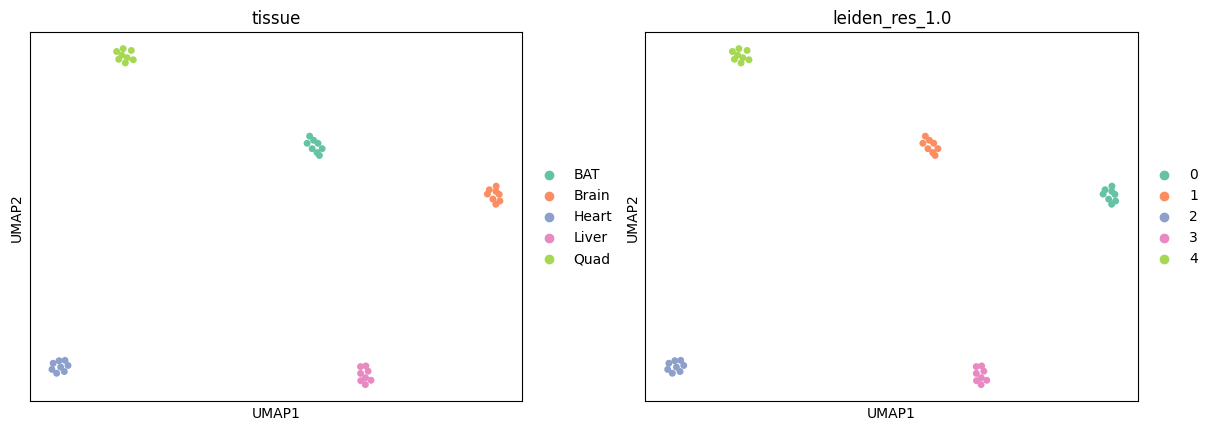

In [ ]:
leiden_res = 1.0
leiden_key = f'leiden_res_{str(leiden_res)}'

sc.pp.neighbors(adata, n_neighbors=4)
sc.tl.leiden(
    adata,
    flavor='igraph',
    resolution=leiden_res,
    n_iterations=2,
    key_added=leiden_key,
    )
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=['tissue', leiden_key],
    size=100,
    palette=adata.uns['colors_tissue'],
    )

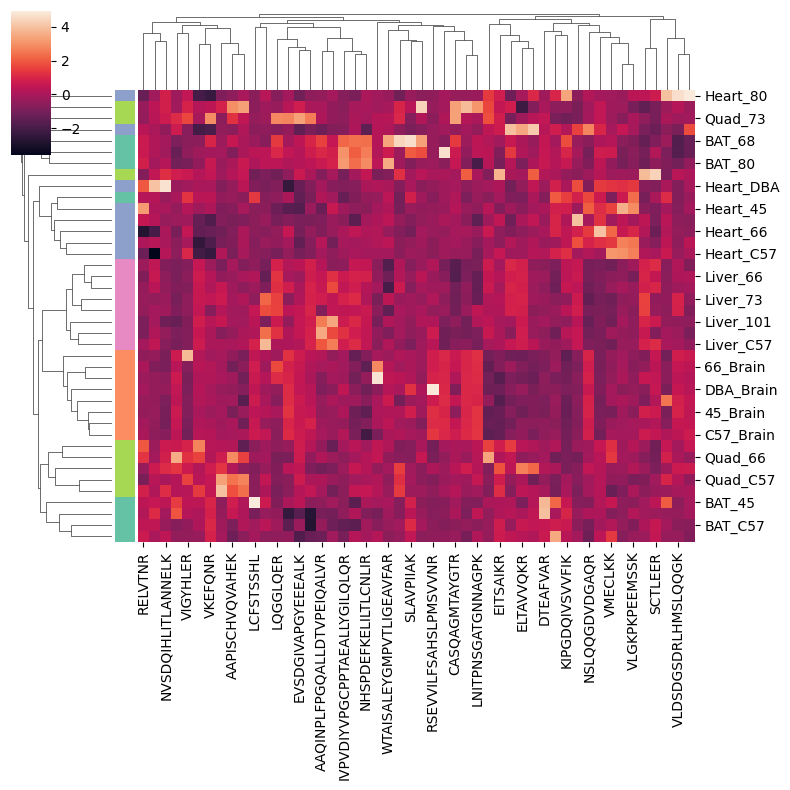

In [ ]:
# 1) Mark the 500 most variable proteins (HVG-style)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=50,
    inplace=True
)

# 2) Get those variable features
adata_var = adata[:, adata.var['highly_variable']].copy()

# 3) Clustered heatmap (Scanpy style)
sc.pl.clustermap(
    adata_var,
    obs_keys='tissue',
    z_score=1,
    figsize=(8,8),
    dendrogram_ratio=0.15,
    show=True
)

In [ ]:
adata.layers["no_imputed"] = adata.X.copy()
adata.layers["no_imputed"][adata.layers["bool_imputed"].astype(bool)] = np.nan

In [ ]:
for f in adata_var.var_names[0:3]:
    sc.pl.violin(adata, keys=[f], groupby="tissue", size=6, xlabel=None, layer='no_imputed')

In [ ]:
adata = pr.pp.filter_genes_by_peptide_count(adata, min=5)

In [ ]:
pr.pp.remove_zero_variance_variables(adata, inplace=True)

In [ ]:
pr.tl.pairwise_peptide_correlations(adata, protein_id='protein_id')
pr.tl.peptide_dendograms_by_correlation(adata, method='agglomerative-hierarchical-clustering')
pr.tl.peptide_clusters_from_dendograms(adata, n_clusters=2, min_peptides_per_cluster=2)
pr.tl.proteoform_scores(adata, alpha=0.4)
pr.pl.proteoform_scores(adata, adj=True, pval_threshold=0.1, score_threshold=0.1)

In [ ]:
Q9JKS4_proteoforms = pr.get.proteoforms_df(
    adata,
    proteins="Q9JKS4",
    #score_threshold=0.1,
    #pval_adj_threshold=0.1,
    #only_proteins=True,
    )

Q9JKS4_proteoforms

In [ ]:
pr.get.proteoforms_df(
    adata,
    proteins="Q3UTJ2",
    #score_threshold=0.1,
    #pval_adj_threshold=0.1,
    #only_proteins=True,
    )

In [ ]:
pr.pl.proteoform_intensities(
    adata,
    "Q9JKS4",
    group_by='tissue',
    xlab_rotation=45,
    #log_transform=True,
    #z_transform=True,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
pr.pl.proteoform_intensities(
    adata,
    "Q3UTJ2",
    group_by='tissue',
    xlab_rotation=45,
    #log_transform=True,
    #z_transform=True,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def plot_peptides_on_sequence(
    sequence: str,
    df: pd.DataFrame,                     # requires columns: peptide_id, proteoform_id
    colors: dict | list | None = None,    # optional: {"pfA": "#...", "pfB": "#..."} or list
    tick_every: int = 100,                # default per your request
    figsize=(12, 2.5),
    show: bool = True,
    save: str | None = None,
    ax: bool = False,
):
    """
    Highlight df['peptide_id'] occurrences on the protein sequence, colored by df['proteoform_id'].
    - Case-insensitive matching (always).
    - One horizontal lane per proteoform_id.
    - No text annotations on peptide blocks.

    Returns
    -------
    fig, ax, hits_df
        hits_df columns: ["proteoform_id","peptide_id","start","end","length","lane"]
    """
    # --- normalize inputs (always case-insensitive)
    seq = sequence.upper()
    df = df.copy()
    df["peptide_id"] = df["peptide_id"].astype(str).str.upper()
    df["proteoform_id"] = df["proteoform_id"].astype(str)

    # --- colors by proteoform
    proteoforms = df["proteoform_id"].unique().tolist()
    if colors is None:
        palette = dict(zip(proteoforms, sns.color_palette(n_colors=len(proteoforms))))
    elif isinstance(colors, list):
        if len(colors) < len(proteoforms):
            raise ValueError("colors list shorter than number of proteoforms.")
        palette = dict(zip(proteoforms, colors))
    elif isinstance(colors, dict):
        palette = colors
    else:
        raise TypeError("colors must be None, list, or dict.")

    # --- helper: find all occurrences (1-based inclusive)
    def _find_all(haystack: str, needle: str):
        spans = []
        start = 0
        while True:
            idx = haystack.find(needle, start)
            if idx == -1:
                break
            spans.append((idx + 1, idx + len(needle)))  # 1-based coordinates
            start = idx + 1
        return spans

    # --- collect matches
    hits, not_found = [], []
    for _, row in df.iterrows():
        pep = row["peptide_id"]
        pf  = row["proteoform_id"]
        spans = _find_all(seq, pep)
        if not spans:
            not_found.append((pf, pep))
        else:
            for s, e in spans:
                hits.append({
                    "proteoform_id": pf,
                    "peptide_id": pep,
                    "start": s,
                    "end": e,
                    "length": e - s + 1
                })

    hits_df = pd.DataFrame(hits)
    if hits_df.empty:
        raise ValueError("No peptides from the table were found in the provided sequence.")

    # --- one lane per proteoform_id
    pf_to_lane = {pf: i for i, pf in enumerate(sorted(proteoforms))}
    hits_df["lane"] = hits_df["proteoform_id"].map(pf_to_lane)
    n_lanes = len(pf_to_lane)
    lane_labels = {v: k for k, v in pf_to_lane.items()}

    # --- plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    # baseline
    ax.hlines(y=[i + 0.5 for i in range(n_lanes)], xmin=1, xmax=len(seq), colors="#cccccc", linewidth=1)

    # peptide rectangles (no text annotations)
    height = 0.7
    for _, r in hits_df.iterrows():
        y = r["lane"] + 0.15
        ax.add_patch(plt.Rectangle(
            (r["start"], y), r["length"], height,
            facecolor=palette[r["proteoform_id"]],
            edgecolor="none", alpha=0.95
        ))

    # axes & ticks
    ax.set_xlim(1, len(seq) + 1)
    ax.set_ylim(0, n_lanes + 1)
    ax.set_xlabel("Residue position")
    ax.set_ylabel("proteoform_id")
    if tick_every and tick_every > 0:
        ax.set_xticks(np.arange(0, len(seq) + 1, tick_every))
    else:
        ax.set_xticks([])

    ax.set_yticks([i + 0.5 for i in range(n_lanes)])
    ax.set_yticklabels([lane_labels[i] for i in range(n_lanes)])

    # legend
    legend_handles = [Patch(facecolor=palette[pf], edgecolor="none", label=str(pf)) for pf in proteoforms]
    ax.legend(handles=legend_handles, title="proteoform_id",
              frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

    sns.despine(ax=ax, left=False)
    plt.tight_layout()

    # warnings for misses (non-fatal)
    if not_found:
        missing = pd.DataFrame(not_found, columns=["proteoform_id", "peptide_id"]).drop_duplicates()
        print(f"Warning: {len(missing)} peptide(s) not found in sequence:\n{missing.to_string(index=False)}")

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")

    if show:
        plt.show()

    if ax:
        return ax


In [ ]:
sequence = "MSYSVTLTGPGPWGFRLQGGKDFNMPLTISRITPGSKAAQSQLSQGDLVVAIDGVNTDTMTHLEAQNKIKSASYNLSLTLQKSKRPIPISTTAPPIQSPLPVIPHQKDPALDTNGSLATPSPSPEARASPGALEFGDTFSSSFSQTSVCSPLMEASGPVLPLGSPVAKASSEGAQGSVSPKVLPGPSQPRQYNNPIGLYSAETLREMAQMYQMSLRGKASGAGLLGGSLPVKDLAVDSASPVYQAVIKTQSKPEDEADEWARRSSNLQSRSFRILAQMTGTEYMQDPDEEALRRSSTPIEHAPVCTSQATSPLLPASAQSPAAASPIAASPTLATAAATHAAAASAAGPAASPVENPRPQASAYSPAAAASPAPSAHTSYSEGPAAPAPKPRVVTTASIRPSVYQPVPASSYSPSPGANYSPTPYTPSPAPAYTPSPAPTYTPSPAPTYSPSPAPAYTPSPAPNYTPTPSAAYSGGPSESASRPPWVTDDSFSQKFAPGKSTTTVSKQTLPRGAPAYNPTGPQVTPLARGTFQRAERFPASSRTPLCGHCNNVIRGPFLVAMGRSWHPEEFNCAYCKTSLADVCFVEEQNNVYCERCYEQFFAPICAKCNTKIMGEVMHALRQTWHTTCFVCAACKKPFGNSLFHMEDGEPYCEKDYINLFSTKCHGCDFPVEAGDKFIEALGHTWHDTCFICAVCHVNLEGQPFYSKKDKPLCKKHAHAINV"
table = adata.var[adata.var.protein_id == "Q9JKS4"][['peptide_id','proteoform_id']].reset_index(drop=True)

plot_peptides_on_sequence(
    sequence,
    table,
    figsize=(12, 3)
)


In [ ]:
sequence = "MSYSVTLTGPGPWGFRLQGGKDFNMPLTISRITPGSKAAQSQLSQGDLVVAIDGVNTDTMTHLEAQNKIKSASYNLSLTLQKSKRPIPISTTAPPIQSPLPVIPHQKVVANSPANADYQERFNPSVLKDSALSTHKPIEVKGLGGKATIIHAQYNTPISMYSQDAIMDAIAGQAQAQGSDFSGASPLASLPVKDLAVDSASPVYQAVIKTQSKPEDEADEWARRSSNLQSRSFRILAQMTGTEYMQDPDEEALRRSSTPIEHAPVCTSQATSPLLPASAQSPAAASPIAASPTLATAAATHAAAASAAGPAASPVENPRPQASAYSPAAAASPAPSAHTSYSEGPAAPAPKPRVVTTASIRPSVYQPVPASSYSPSPGANYSPTPYTPSPAPAYTPSPAPTYTPSPAPTYSPSPAPAYTPSPAPNYTPTPSAAYSGGPSESASRPPWVTDDSFSQKFAPGKSTTTVSKQTLPRGAPAYNPTGPQVTPLARGTFQRAERFPASSRTPLCGHCNNVIRGPFLVAMGRSWHPEEFNCAYCKTSLADVCFVEEQNNVYCERCYEQFFAPICAKCNTKIMGEVMHALRQTWHTTCFVCAACKKPFGNSLFHMEDGEPYCEKDYINLFSTKCHGCDFPVEAGDKFIEALGHTWHDTCFICAVCHVNLEGQPFYSKKDKPLCKKHAHAINV"
table = adata.var[adata.var.protein_id == "Q9JKS4"][['peptide_id','proteoform_id']].reset_index(drop=True)

plot_peptides_on_sequence(
    sequence,
    table,
    figsize=(12, 3)
)

In [ ]:
# Q3UTJ2
sequence = "MNTDSGGCARKRAAMSVTLTSVKRVQSSPNLLAAGRESQSPDSAWRSYNDRNPETLNGDATYSSLAAKGFRSVRPNLQDKRSPTQSQITINGNSGGAVSPVSYYQRPFSPSAYSLPASLNSSIIMQHGRSLDSAETYSQHAQSLDGTMGSSIPLYRSSEEEKRVTVIKAPHYPGIGPVDESGIPTAIRTTVDRPKDWYKTMFKQIHMVHKPGLYNSPYSAQSHPAAKTQTYRPLSKSHSDNGTDAFKEVPSPVPPPHVPPRPRDQSSTLKHDWDPPDRKVDTRKFRSEPRSIFEYEPGKSSILQHERPVSIYQSSIDRSLERPSSSASMAGDFRKRRKSEPAVGPLRGLGDQSSSRTSPGRADLPGSSSTFTKSFISSSPSSPSRAQGGDDSKMCPPLCSYSGLNGTPSGELECCNAYRQHLDVPGDSQRAITFKNGWQMARQNAEIWSSTEETVSPKIKSRSCDDLLNDDCDSFPDPKTKSESMGSLLCEEDSKESCPMTWASPYIQEVCGNSRSRLKHRSAHNAPGFLKMYKKMHRINRKDLMNSEVICSVKSRILQYEKEQQHRGLLHGWSQSSTEEVPRDVVPTRISEFEKLIQKSKSMPNLGDEMLSPITLEPPQNGLCPKRRFSIESLLEEETQVRHPSQGQRSCKSNTLVPIHIEVTSDEQPRTHMEFSDSDQDGVVSDHSDYVHVEGSSFCSESDFDHFSFTSSESFYGSSHHHHHHHHHHRHLISSCKGRCPASYTRFTTMLKHERAKHENMDRPRRQEMDPGLSKLAFLVSPVPFRRKKILTPQKQTEKAKCKASVVEALDSALKDICDQIKAEKRRGSLPDNSILHRLISELLPQIPERNSSLHALKRSPMHQPFHPLPPDGASHCPLYQNDCGRMPHSASFPDVDTTSNYHAQDYGSALSLQDHESPRSYSSTLTDLGRSASRERRGTPEKEKLPAKAVYDFKAQTSKELSFKKGDTVYILRKIDQNWYEGEHHGRVGIFPISYVEKLTPPEKAQPARPPPPVQPGEIGEAIAKYNFNADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPVSYVEVVKRNAKGAEDYPDPPLPHSYSSDRIYTLSSNKPQRPGFSHENIQGGGEPFQALYNYTPRNEDELELRESDVVDVMEKCDDGWFVGTSRRTKFFGTFPGNYVKRL"
table = adata.var[adata.var.protein_id == "Q3UTJ2"][['peptide_id','proteoform_id']].reset_index(drop=True)

plot_peptides_on_sequence(
    sequence,
    table,
    figsize=(12, 3)
)


In [ ]:
# Q3UTJ2
sequence = "MNTGRESQSPDSAWRSYNDRNPETLNGDATYSSLAAKGFRSVRPNLQDKRSPTQSQITINGNSGGAVSPVSYYQRPFSPSAYSLPASLNSSIIMQHGRSLDSAETYSQHAQSLDGTMGSSIPLYRSSEEEKRVTVIKAPHYPGIGPVDESGIPTAIRTTVDRPKDWYKTMFKQIHMVHKPDEDTDMYNTPYTYNAGLYNSPYSAQSHPAAKTQTYRPLSKSHSDNGTDAFKEVPSPVPPPHVPPRPRDQSSTLKHDWDPPDRKVDTRKFRSEPRSIFEYEPGKSSILQHERPVSIYQSSIDRSLERPSSSASMAGDFRKRRKSEPAVGPLRGLGDQSSSRTSPGRADLPGSSSTFTKSFISSSPSSPSRAQDHESPRSYSSTLTDLGRSASRERRGTPEKEKLPAKAVYDFKAQTSKELSFKKGDTVYILRKIDQNWYEGEHHGRVGIFPISYVEKLTPPEKAQPARPPPPVQPGEIGEAIAKYNFNADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPVSYVEVVKRNAKGAEDYPDPPLPHSYSSDRIYTLSSNKPQRPGFSHENIQGGGEPLQ"
table = adata.var[adata.var.protein_id == "Q3UTJ2"][['peptide_id','proteoform_id']].reset_index(drop=True)

plot_peptides_on_sequence(
    sequence,
    table,
    figsize=(12, 3)
)

### @TODO: Proteoform quantification
For the ANOVA analysis, we selected proteoforms based on a proteoform score cutoff of 0.1 and adj. p-value threshold of 0.1. Outlier peptides from the clustering were removed prior to proteoform quantification, which was performed by proteinQuantification (quantLevel = “proteoform_id”, topN = 1000, keep_less = TRUE).

In [ ]:
adata_prot = pr.tl.quantify_by_var(
    adata,
    group_by = "protein_id", 
    inplace = False,
)

In [ ]:
adata_prot.var

In [ ]:
pr.pl.n_detected_proteins_per_sample(
    adata_prot,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    xlabel_rotation=10,
    group_by_label_rotation=10
    )

In [ ]:
pr.pl.peptide_intensities(
    adata_prot,
    "Q9JKS4",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
adata_proteoform = pr.tl.quantify_by_var(
    adata,
    group_by = "proteoform_id",
    inplace = False,
)

In [ ]:
adata_proteoform.var

In [ ]:
pr.pl.n_detected_proteins_per_sample(
    adata_proteoform,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    xlabel_rotation=10,
    group_by_label_rotation=10
    )

In [ ]:
adata_proteoform.var

In [ ]:
pr.pl.peptide_intensities(
    adata_proteoform,
    "Q9JKS4",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
pr.pl.peptide_intensities(
    adata_proteoform,
    "Q3UTJ2",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

# @ToDo: Differential analysis!